In [1]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
### Provide ubc_data_relevant_splitted directory to your google drive, which is the original contest provided data,
# trimmed to "relevant users" (arbitrary subset of milion users, provided with dataset),
# and with out-of-date data split performed on it.

In [2]:
! ls /content/drive/MyDrive/ubc_data_relevant/
ubc_data_path = '/content/drive/MyDrive/ubc_data_relevant_splitted'
ubc_input_path = f'{ubc_data_path}/input'
target_path = f'{ubc_data_path}/target'

add_to_cart.parquet  product_buy.parquet	 search_query.parquet
input		     product_properties.parquet  target
page_visit.parquet   remove_from_cart.parquet


In [3]:
! rm -rf recsys2025_challenge

In [4]:
! test -f recsys2025_challenge || git clone --recurse-submodules --remote-submodules https://github.com/zmrocze/recsys2025_challenge.git

Cloning into 'recsys2025_challenge'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 385 (delta 5), reused 10 (delta 3), pack-reused 372 (from 1)
Receiving objects: 100% (385/385), 4.03 MiB | 5.83 MiB/s, done.
Resolving deltas: 100% (259/259), done.
Submodule 'recsys2025' (https://github.com/Synerise/recsys2025.git) registered for path 'recsys2025'
Cloning into '/content/recsys2025_challenge/recsys2025'...
remote: Enumerating objects: 75, done.        
remote: Counting objects: 100% (23/23), done.        
remote: Compressing objects: 100% (12/12), done.        
remote: Total 75 (delta 11), reused 11 (delta 11), pack-reused 52 (from 1)        
Receiving objects: 100% (75/75), 50.74 KiB | 447.00 KiB/s, done.
Resolving deltas: 100% (22/22), done.
Submodule path 'recsys2025': checked out 'a39c09c7cdbb559db3f2942b2509a716baae1d59'


In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
import sys

# Below paths: bad but managable

module_path = os.path.abspath(os.path.join('./recsys2025_challenge'))
sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('./recsys2025_challenge/recsys2025'))
sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('./recsys2025_challenge/src/our_lib'))
sys.path.append(module_path)

In [6]:
! pip install pytorch-lightning torchmetrics neptune pyarrow
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.9/487.9 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:0

# load data

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
# load everything
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torchmetrics as tm

In [9]:
from src.our_lib import RecSysData, unique_edges, load_target, drop_duplicates, all_categories_in_df_numpy, all_users_in_df_numpy, all_items_in_df_numpy, join_item_with_category

In [10]:
input_data = RecSysData.read_parquet(ubc_input_path)
product_properties = pd.read_parquet(f'{ubc_data_path}/product_properties.parquet')
all_input_users = input_data.all_users_set()
all_categories = all_categories_in_df_numpy(product_properties)
input_data

RecSysData(
  add_to_cart=1922253,
  page_visit=32941261,
  product_buy=939835,
  product_properties=1197634,
  remove_from_cart=800359,
  search_query=3204721,
  all users: 858489,
  all products: 674374
  all urls: 5185400,
)

In [11]:
delattr(input_data, 'page_visit')
delattr(input_data, 'search_query')

In [12]:
target_data = load_target(target_path)
train_target = target_data['train_target']
valid_target = target_data['validation_target']

In [13]:
input_data.add_to_cart = join_item_with_category(input_data.add_to_cart, product_properties)
input_data.remove_from_cart = join_item_with_category(input_data.remove_from_cart, product_properties)
input_data.product_buy = join_item_with_category(input_data.product_buy, product_properties)

In [14]:
first_train_timestamp = train_target['timestamp'].min()
first_valid_timestamp = valid_target['timestamp'].min()

print(f"First timestamp in train_target: {first_train_timestamp}")
print(f"First timestamp in valid_target: {first_valid_timestamp}")

First timestamp in train_target: 2022-09-13 00:03:35
First timestamp in valid_target: 2022-09-27 00:00:15


In [15]:
print(input_data.add_to_cart['timestamp'].min())
print(input_data.remove_from_cart['timestamp'].min())
print(input_data.product_buy['timestamp'].min())
print(input_data.add_to_cart['timestamp'].max())
print(input_data.remove_from_cart['timestamp'].max())
print(input_data.product_buy['timestamp'].max())

2022-05-23 00:10:15
2022-05-23 00:12:20
2022-05-23 00:10:40
2022-09-12 23:59:45
2022-09-12 23:58:10
2022-09-12 23:58:35


In [16]:
# drop duplicates
aaxxrta = 'category' # 'sku'
drop_duplicates(input_data.add_to_cart, subset=['client_id', aaxxrta])
drop_duplicates(input_data.remove_from_cart, subset=['client_id', aaxxrta])
drop_duplicates(input_data.product_buy, subset=['client_id', aaxxrta])

drop_duplicates(train_target, subset=['client_id', aaxxrta])
drop_duplicates(valid_target, subset=['client_id', aaxxrta])

# print all the lengths
print(f"add_to_cart: {len(input_data.add_to_cart)}")
print(f"remove_from_cart: {len(input_data.remove_from_cart)}")
print(f"product_buy: {len(input_data.product_buy)}")
print(f"train_target: {len(train_target)}")
print(f"valid_target: {len(valid_target)}")

print(f"len(users) x len(categories): {len(all_input_users) * len(all_categories)}")

add_to_cart: 1922253
remove_from_cart: 800359
product_buy: 939835
train_target: 130109
valid_target: 148479
len(users) x len(categories): 5480593776


In [17]:
# input_data.print_datasets_stats_nicely("input data")

In [18]:
train_users_set = set(train_target['client_id'].unique())
valid_users_set = set(valid_target['client_id'].unique())

In [19]:
len(all_input_users)

858489

In [20]:
len(valid_users_set.union(train_users_set))

130097

In [21]:
# Get users who have only one interaction across all input data types
all_interactions = pd.concat([
  input_data.add_to_cart[['client_id']],
  # input_data.remove_from_cart[['client_id']],
  input_data.product_buy[['client_id']]
])

user_interaction_counts = all_interactions['client_id'].value_counts()
big_interaction_users = set(user_interaction_counts[user_interaction_counts >= 5].index)
# huge_interaction_users = set(user_interaction_counts[user_interaction_counts >= 100].index)
include_users = big_interaction_users.intersection(
        (valid_users_set).union(train_users_set)
      )

print(f"Users with 5+ interactions: {len(big_interaction_users)}")
print(f"Users with 5+ interactions and in train or valid: {len(big_interaction_users.intersection((valid_users_set).union(train_users_set)))}")
# print(f"Users with 100+: {len(huge_interaction_users)}")
print(f"All included: {len(include_users)}")


Users with 10+ interactions: 149285
Users with 10+ interactions and in train or valid: 21233
All included: 21233


In [22]:
# removing these, no information gained
input_data.add_to_cart = input_data.add_to_cart[input_data.add_to_cart['client_id'].isin(include_users)]
input_data.remove_from_cart = input_data.remove_from_cart[input_data.remove_from_cart['client_id'].isin(include_users)]
input_data.product_buy = input_data.product_buy[input_data.product_buy['client_id'].isin(include_users)]

In [23]:
_known_categories = set(input_data.add_to_cart['category'].unique()).union(
    # set(input_data.remove_from_cart['category'].unique())).union(
    set(input_data.product_buy['category'].unique()))
known_users = set(input_data.add_to_cart['client_id'].unique()).union(
    # set(input_data.remove_from_cart['client_id'].unique())).union(
    set(input_data.product_buy['client_id'].unique()))

len(_known_categories), len(known_users), len(all_categories)

(4684, 21233, 6384)

In [24]:
train_target_known = train_target[train_target['client_id'].isin(known_users)]
valid_target_known = valid_target[valid_target['client_id'].isin(known_users)]
print(f"train_target_known: {len(train_target_known)}")
print(f"valid_target_known: {len(valid_target_known)}")

train_target_known: 35264
valid_target_known: 35783


# training gat

In [25]:
# imports
# from src.our_lib import NodeIdMap, JustGAT, RecGAT, DotproductEdgePredictor, LinearEdgePredictor, BprLossLoader
# from src.our_lib import test_out, l2_reg, train_test_split_pos_edges, int_tensor, unique_edges
from src.our_lib import create_val_edge_batched, NodeIdMap, JustGAT, RecGAT, DotproductEdgePredictor, LinearEdgePredictor, BprLossLoader, test_out, l2_reg, train_test_split_pos_edges, int_tensor, unique_edges, loss_f, BprTraining, RecLightGCN, JustLightGCN
import random

In [26]:
### NOTE!:
### There are 2 types of ids: product has sku    and the id of a product node in graph (can exchange with node_id_map.item_of_id/id_of_item).
#                             user has client_id and the id of a user    node in graph

node_id_map = NodeIdMap(known_users, all_categories)
train_edge_index = node_id_map.make_edges(train_target_known.client_id.values, train_target_known.category.values).to(device=device)
val_edge_index = node_id_map.make_edges(valid_target_known.client_id.values, valid_target_known.category.values).to(device=device)

N = node_id_map.N

In [27]:

def make_loaders(neg_samples, batch_size):
  ### these are edges used for loss calculation
  ### and they define the graph (maybe together with product_buy, remove_from_cart)
  train_loader = BprLossLoader(
      edge_index=train_edge_index,
      trg_index_range=(node_id_map.n_users, node_id_map.N), # node index range for all items (used to sample negative items)
      batch_size=batch_size,
      neg_samples=neg_samples,
      random_state=42,
      device=device
  )

  test_loader = BprLossLoader(
    edge_index=val_edge_index,
    trg_index_range=(node_id_map.n_users, node_id_map.N),  # node index range for all items (used to sample negative items)
    batch_size=batch_size,
    neg_samples=neg_samples,
    random_state=42,
    device=device
  )
  return train_loader, test_loader

neg_samples = 5
batch_size = 1024

train_loader, test_loader = make_loaders(neg_samples, batch_size)

In [ ]:
## This is preprocessing that makes auroc calculation during training faster.
auroc_batch_size=100
val_edge_index_batched = create_val_edge_batched(node_id_map, val_edge_index, auroc_batch_size, device='cpu')

In [ ]:
import pytorch_lightning as pl

class LogAuroc(pl.Callback):
  def __init__(self):
    super().__init__()
    self.best_auroc = float('-inf')

  def on_train_start(self, trainer, pl_module):
    print("Logging initial auroc...")
    if pl_module.val_edge_index_batched is not None:
      full_auroc = pl_module.auroc_og()
      pl_module.log("val_auroc", full_auroc)

  def on_validation_epoch_end(self, trainer, pl_module):
    if pl_module.val_edge_index_batched is not None:
      full_auroc = pl_module.auroc_og()
      self.best_auroc = max(self.best_auroc, full_auroc)
      pl_module.log("val_auroc", full_auroc)


In [ ]:
###
###

def make_model(**kwargs):
  ### define graph: either lightgcn or gat
  new_model = None
  if kwargs['model_type'] == 'gat':
    new_recgat = lambda: RecGAT(known_users, all_categories, embedding_dim=embedding_dim, edge_dim=edge_dim, num_layers=num_layers, device=device, dropout=dropout_gat, type=init_type, a=init_a)
    recgat = new_recgat()
    edge_attr_add_to_cart = torch.tensor([[1, 0, 0]], dtype=torch.float).repeat(len(input_data.add_to_cart), 1).to(device)
    edge_attr_remove_from_cart = torch.tensor([[0, 1, 0]], dtype=torch.float).repeat(len(input_data.remove_from_cart), 1).to(device)
    edge_attr_product_buy = torch.tensor([[0, 0, 1]], dtype=torch.float).repeat(len(input_data.product_buy), 1).to(device)

    recgat.add_edges_from_user_category_df(input_data.add_to_cart, edge_attr=edge_attr_add_to_cart)
    recgat.add_edges_from_user_category_df(input_data.remove_from_cart, edge_attr=edge_attr_remove_from_cart)
    recgat.add_edges_from_user_category_df(input_data.product_buy, edge_attr=edge_attr_product_buy)
    # new_model = recgat
  elif kwargs['model_type'] == 'lightgcn':
    new_gcn = lambda: RecLightGCN(known_users, all_categories, embedding_dim=kwargs['embedding_dim'], num_layers=kwargs['num_layers'], device=device, type=kwargs['init_type'], a=kwargs['init_a'])
    recgat = new_gcn()
    recgat.add_edges_from_user_category_df(input_data.add_to_cart)
    # recgat.add_edges_from_user_category_df(input_data.remove_from_cart)
    recgat.add_edges_from_user_category_df(input_data.product_buy)
  else:
    raise ValueError(f"Unknown model_type: {kwargs['model_type']}")

  ### edge predictor (here: only for product_buy edges. todo: predict more stuff (like next purchased category in next 14days from propensity categories) with more varied predictors and combine losses)
  if kwargs['edge_predictor_type'] == 'linear':
    edge_predictor = LinearEdgePredictor(embedding_dim=kwargs['embedding_dim'], dropout=kwargs['dropout_edge']).to(device=device)
  elif kwargs['edge_predictor_type'] == 'dot':
    edge_predictor = DotproductEdgePredictor(kwargs['embedding_dim']).to(device=device)

  # pytorch lightning module
  model = BprTraining(
      recgat=recgat,
      edge_predictor=edge_predictor,
      lr=kwargs['lr'],
      l2_reg=kwargs['l2_reg'],
      # propensity_sku=sampled_items, # for auroc calc
      auroc_batch_size=kwargs['auroc_batch_size'],
      retain_grad=(kwargs['accumulate_grad_batches']>1),
      val_edge_index_batched=val_edge_index_batched,
      val_edge_index=val_edge_index,
      patience=kwargs['patience'],
      threshold = kwargs['threshold'],
      cooldown=kwargs['cooldown'],
      factor=kwargs['lr_reduce_factor'],
      lr_scheduler_monitor=kwargs['lr_scheduler_monitor'],
      device=device,
      # forward_gat_every_n = 20, ### tradeoff : speed vs training stability
      # this has to be fixed and work with n>1, this is slow, use big batch to make up for it:
      # forward_gat_every_n = accumulate_grad_batches,
    )

  ### sillynes
  # model = remake_model_if_loss_nan(model)
  return model


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
import wandb

def trial(**kwargs):

  train_loader, test_loader = make_loaders(kwargs["neg_samples"], kwargs["batch_size"])

  model_checkpoint_val = ModelCheckpoint(
      monitor='val_loss',
      auto_insert_metric_name=True,
      save_top_k=1,
      mode='min',
  )
  model_checkpoint_auroc = ModelCheckpoint(
    monitor='val_auroc',
    auto_insert_metric_name=True,
    mode = 'max',
    save_top_k=1,
  )

  log_auroc = LogAuroc()

  log_lr = LearningRateMonitor(logging_interval='epoch')
  # lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau()

  # model = remake_model_if_loss_nan(make_model)
  model = make_model(**kwargs)

  log_model = True
  trial_k = random.randint(0, 100000)
  print(trial_k)
  wandb.finish()
  wandb_logger = WandbLogger(
    # project="recsys_categories",
    project="recsys2025_lightgcn",
    name=f"bpr_lightgcn_{trial_k}",
    log_model=True
    )
  wandb_logger.experiment.config.update({
    "model_type" : kwargs['model_type'],
    "edge_predictor_type": kwargs['edge_predictor_type'],
    "embedding_dim": kwargs['embedding_dim'],
    "edge_dim": kwargs['edge_dim'],
    "num_layers": kwargs['num_layers'],
    "dropout_gat": kwargs['dropout_gat'],
    "init_type": kwargs['init_type'],
    "init_a": kwargs['init_a'],
    "dropout_edge": kwargs['dropout_edge'],
    "lr": kwargs['lr'],
    "l2_reg": kwargs['l2_reg'],
    "batch_size": kwargs['batch_size'],
    "auroc_batch_size": kwargs['auroc_batch_size'],
    "accumulate_grad_batches": kwargs['accumulate_grad_batches'],
    "neg_samples": kwargs['neg_samples'],
    "log_model": kwargs['log_model'],
    "graph_items": model.recgat.node_id_map.n_items,
    "graph_users": model.recgat.node_id_map.n_users,
    "graph_edges_n": model.recgat.edge_index.size(1),
    "train_edges_n": train_edge_index.size(1),
    "val_edges_n": val_edge_index.size(1),
  })

  trainer = pl.Trainer(  max_epochs=kwargs['max_epochs']
                      , check_val_every_n_epoch=kwargs['check_val_every_n_epoch']
                      , logger=wandb_logger
                       , callbacks=[model_checkpoint_auroc, model_checkpoint_val, log_auroc, log_lr]
                      , accumulate_grad_batches=kwargs['accumulate_grad_batches']
                        #,   retain_grad=True
                      #  , terminate_on_nan=True
                      )

  wandb_logger.watch(model, log="all")

  ## return the trained model on exit
  def end(model, trainer, log_auroc):
    model = model.cuda() # lightning sillynes
    val_auroc = model.auroc_og()
    log_auroc.best_auroc = max(log_auroc.best_auroc, val_auroc)
    return val_auroc, log_auroc.best_auroc, model, trainer
  try:
    try:
      trainer.fit(model, train_loader, val_dataloaders=test_loader)
    except KeyboardInterrupt:
      print("KeyboardInterrupt")
      return end(model, trainer, log_auroc)
  except NameError:
    return end(model, trainer, log_auroc)
  return end(model, trainer, log_auroc)

In [ ]:
embedding_dim = 64
init_type='normal'
# lr reduce on platteou
patience=30
threshold=0.05
cooldown=30
lr_reduce_factor=0.2
dropout_edge=0.5
max_epochs=150
lr=0.0001
l2_reg=0.001
init_a=1.0
accumulate_grad_batches=1
dropout_gat=0.3
edge_dim = 3
check_val_every_n_epoch=3
lr_scheduler_monitor="train_loss"

model_type = 'lightgcn' # 'gat
edge_predictor_type = 'dot'
num_layers=4
neg_samples=100
batch_size=1024

config  = {
  "model_type" : model_type,
  "auroc_batch_size":  auroc_batch_size,
  "neg_samples":  neg_samples,
  "batch_size":  batch_size,
  "embedding_dim":  embedding_dim,
  'edge_predictor_type' : edge_predictor_type,
  "edge_dim":  edge_dim,
  "num_layers":  num_layers,
  "dropout_gat":  dropout_gat,
  "init_type":  init_type,
  "init_a":  init_a,
  "dropout_edge":  dropout_edge,
  "lr":  lr,
  "l2_reg":  l2_reg,
  "accumulate_grad_batches":  accumulate_grad_batches,
  "check_val_every_n_epoch":  check_val_every_n_epoch,
  "patience":  patience,
  "threshold":0.005,
  "cooldown":20,
  "lr_reduce_factor":  lr_reduce_factor,
  "lr_scheduler_monitor":  lr_scheduler_monitor,
  "max_epochs":  max_epochs,
  "log_model":  True,
  "neg_samples": neg_samples,
  "batch_size": batch_size,
}

# trial(**config)

In [ ]:
results_model_type = {}

for model_type in ['gat', 'lightgcn']:
  config1 = config.copy()
  config1['model_type'] = model_type
  last_auroc, best_auroc, model, trainer =  trial(**config1)
  results_model_type[model_type] = {
    "best_val_auroc" : best_auroc,
    "last_val_auroc": last_auroc,
    "model": model,
    "trainer": trainer
  }
  print(f"model_type: {model_type}, last_val_auroc: {last_auroc}, best_val_auroc: {best_auroc}")

60709


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecGAT                  | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.274     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


model_type: gat, last_val_auroc: 0.4870083001265264, best_val_auroc: 0.4870083001265264
13116


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecLightGCN             | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.070     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


model_type: lightgcn, last_val_auroc: 0.5099034133519508, best_val_auroc: 0.5099034133519508


In [ ]:
results_edge_predictor_type = {}

for edge_predictor_type in ['linear', 'dot']:
  config1 = config.copy()
  config1['edge_predictor_type'] = edge_predictor_type
  last_auroc, best_auroc, model, trainer =  trial(**config1)
  results_edge_predictor_type[edge_predictor_type] = {
    "best_val_auroc" : best_auroc,
    "last_val_auroc": last_auroc,
    "model": model,
    "trainer": trainer
  }
  print(f"edge_predictor_type: {edge_predictor_type}, last_val_auroc: {last_auroc}, best_val_auroc: {best_auroc}")

56562


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | recgat         | RecLightGCN         | 1.8 M  | train
1 | edge_predictor | LinearEdgePredictor | 8.3 K  | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.103     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


edge_predictor_type: linear, last_val_auroc: 0.3540150663172619, best_val_auroc: 0.3540150663172619
1481


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecLightGCN             | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.070     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


edge_predictor_type: dot, last_val_auroc: 0.5065894368027274, best_val_auroc: 0.5065894368027274


In [ ]:
results_num_layers = {}
for num_layers in [2, 3 , 4, 5]:
  config1 = config.copy()
  config1['num_layers'] = num_layers
  last_auroc, best_auroc, model, trainer =  trial(**config1)
  results_num_layers[num_layers] = {
    "best_val_auroc" : best_auroc,
    "last_val_auroc": last_auroc,
    "model": model,
    "trainer": trainer
  }
  print(f"num_layers: {num_layers}, last_val_auroc: {last_auroc}, best_val_auroc: {best_auroc}")

67794


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecLightGCN             | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.070     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


num_layers: 2, last_val_auroc: 0.5287367175295383, best_val_auroc: 0.5287367175295383
98949


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecLightGCN             | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.070     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


num_layers: 3, last_val_auroc: 0.5156020907903821, best_val_auroc: 0.5156020907903821
10782


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecLightGCN             | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.070     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


num_layers: 4, last_val_auroc: 0.5129604184015729, best_val_auroc: 0.5129604184015729
54376


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecLightGCN             | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.070     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


num_layers: 5, last_val_auroc: 0.4935879022504767, best_val_auroc: 0.4935879022504767


In [ ]:
results_neg_samples = {}
for neg_samples in [10, 50, 100, 150]:
  config1 = config.copy()
  config1['neg_samples'] = neg_samples
  last_auroc, best_auroc, model, trainer =  trial(**config1)
  results_neg_samples[neg_samples] = {
    "best_val_auroc" : best_auroc,
    "last_val_auroc": last_auroc,
    "model": model,
    "trainer": trainer
  }
  print(f"neg_samples: {neg_samples}, last_val_auroc: {last_auroc}, best_val_auroc: {best_auroc}")

44896


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecLightGCN             | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.070     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


neg_samples: 10, last_val_auroc: 0.5109598800957074, best_val_auroc: 0.5109598800957074
55490


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecLightGCN             | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.070     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


neg_samples: 50, last_val_auroc: 0.5005170938029208, best_val_auroc: 0.5005170938029208
98308


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecLightGCN             | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.070     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


neg_samples: 100, last_val_auroc: 0.509900118107878, best_val_auroc: 0.509900118107878
63746


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecLightGCN             | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.070     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

In [ ]:
results_edge_predictor_type_gat = {}
for edge_predictor_type in ["linear", "dot"]:
  config1 = config.copy()
  config1['model_type'] = 'gat'
  config1['edge_predictor_type'] = edge_predictor_type
  last_auroc, best_auroc, model, trainer =  trial(**config1)
  results_edge_predictor_type_gat[edge_predictor_type] = {
    "best_val_auroc" : best_auroc,
    "last_val_auroc": last_auroc,
    "model": model,
    "trainer": trainer
  }
  print(f"(gat) edge_predictor_type: {edge_predictor_type}, last_val_auroc: {last_auroc}, best_val_auroc: {best_auroc}")

In [ ]:
results_num_layers_gat = {}
for num_layers in [2, 3 , 4, 5]:
  config1 = config.copy()
  config1['model_type'] = 'gat'
  config1['num_layers'] = num_layers
  last_auroc, best_auroc, model, trainer =  trial(**config1)
  results_num_layers_gat[num_layers] = {
    "best_val_auroc" : best_auroc,
    "last_val_auroc": last_auroc,
    "model": model,
    "trainer": trainer
  }
  print(f"(gat) num_layers: {num_layers}, last_val_auroc: {last_auroc}, best_val_auroc: {best_auroc}")

In [ ]:
results_model_type_more = {}

# for model_type, edge_predictor_type in [('gat', 'linear'), ('gat', 'dot'), ('lightgcn', 'dot')]:
for model_type, edge_predictor_type in [('gat', 'dot'), ('lightgcn', 'dot'), ('gat', 'linear')]:
  config1 = config.copy()
  config1['model_type'] = model_type
  config1['edge_predictor_type'] = edge_predictor_type
  config1['max_epochs'] = 150
  config1["num_layers"]=  5
  config1["neg_samples"]= 300
  last_auroc, best_auroc, model, trainer =  trial(**config1)
  results_model_type_more[f"{model_type}_{edge_predictor_type}"] = {
    "best_val_auroc" : best_auroc,
    "last_val_auroc": last_auroc,
    "model": model,
    "edge_predictor_type": edge_predictor_type,
    "trainer": trainer
  }
  print(f"model_type: {model_type}_{edge_predictor_type}, last_val_auroc: {last_auroc}, best_val_auroc: {best_auroc}")

29542


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecGAT                  | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.274     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


model_type: gat_dot, last_val_auroc: 0.426019985865506, best_val_auroc: 0.6340768455635046
91471


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | recgat         | RecLightGCN             | 1.8 M  | train
1 | edge_predictor | DotproductEdgePredictor | 0      | train
-------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.070     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


model_type: lightgcn_dot, last_val_auroc: 0.501048887546241, best_val_auroc: 0.5576045947337669
50339


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | recgat         | RecGAT              | 1.8 M  | train
1 | edge_predictor | LinearEdgePredictor | 8.3 K  | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.307     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Logging initial auroc...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


model_type: gat_linear, last_val_auroc: 0.5045677044177396, best_val_auroc: 0.6486221817293186


In [ ]:
# Function to plot results with scaled y-axis
def plot_results(results, title, xlabel):
    keys = sorted(results.keys())
    auroc_scores = [results[key]['best_val_auroc'] for key in keys]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(keys)), auroc_scores)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Validation AUROC')
    plt.xticks(range(len(keys)), keys)

    # Set y-axis limits to better show differences
    min_score = min(auroc_scores)
    max_score = max(auroc_scores)
    margin = (max_score - min_score) * 0.1  # 10% margin
    plt.ylim(min_score - margin, max_score + margin)

    plt.grid(True, axis='y')
    plt.show()


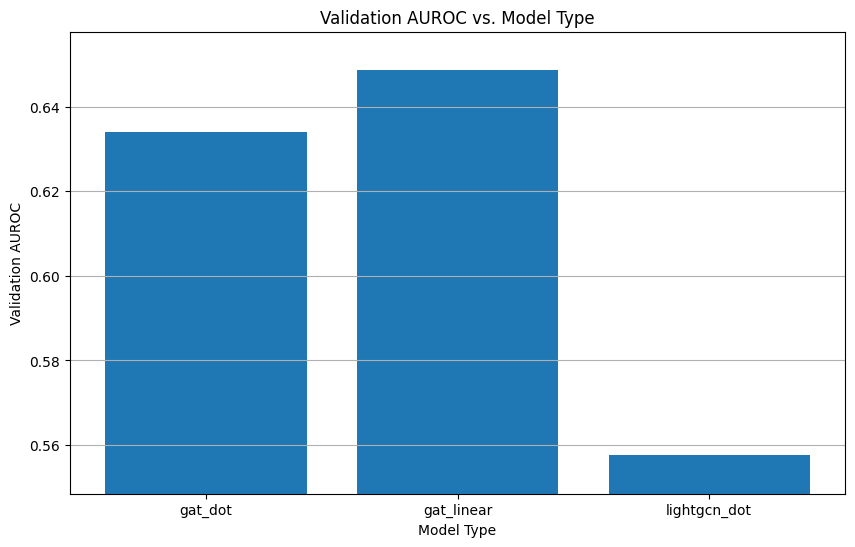

In [ ]:
plot_results(results_model_type_more, 'Validation AUROC vs. Model Type', 'Model Type')

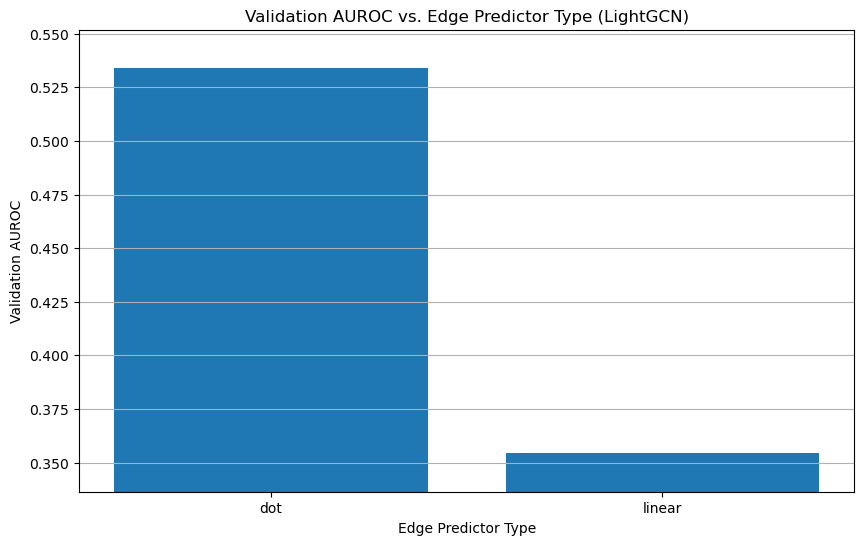

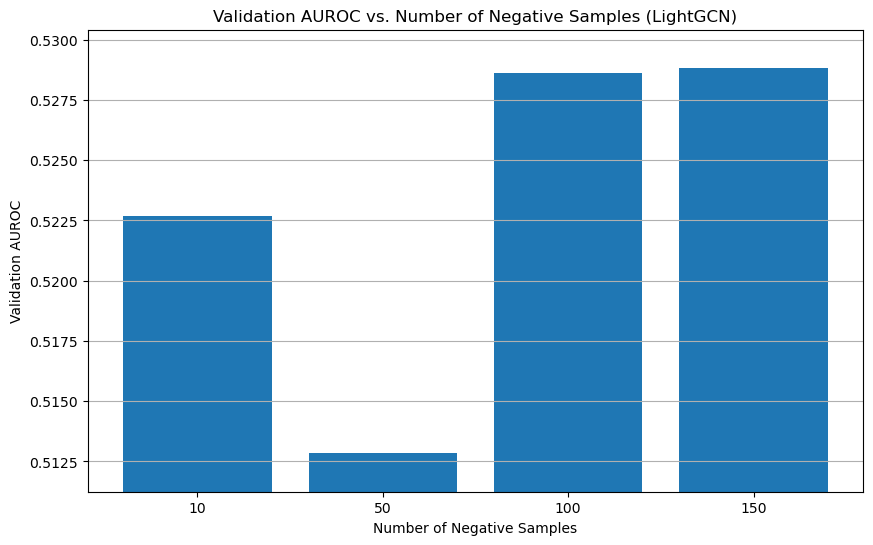

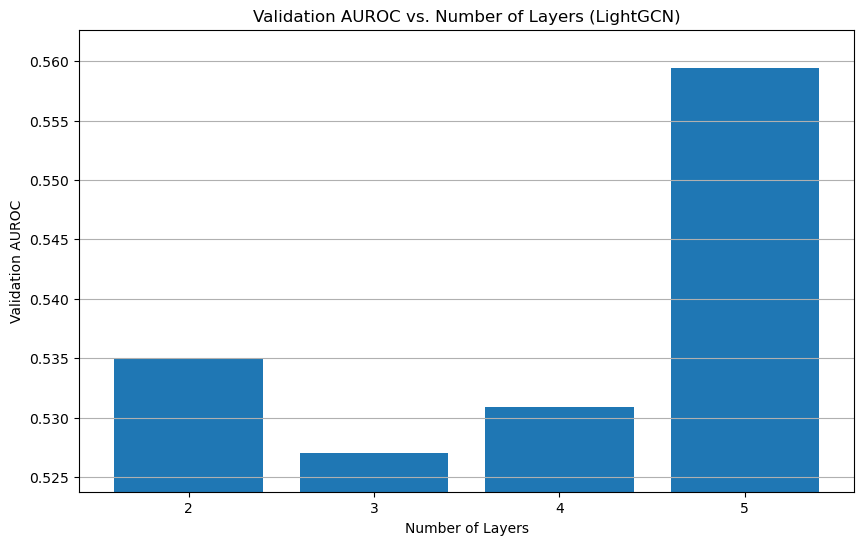

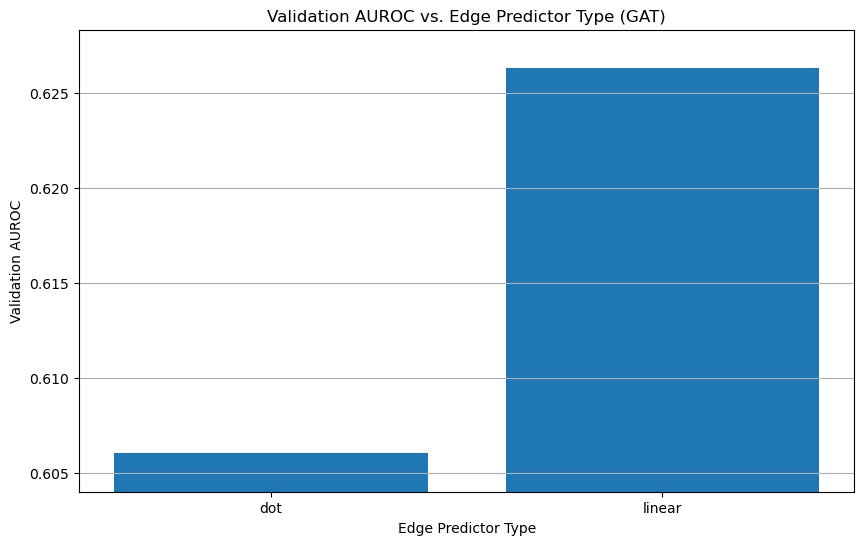

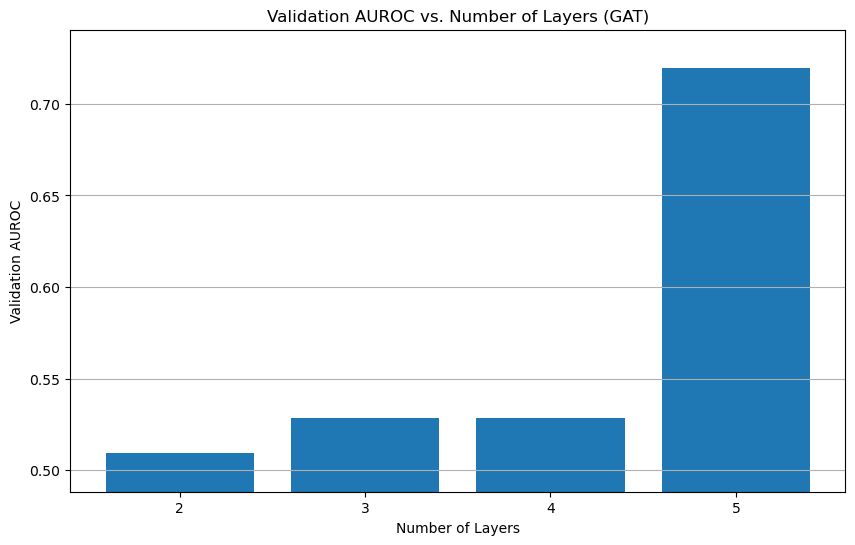

In [ ]:

# Plotting results for different edge predictor types
plot_results(results_edge_predictor_type, 'Validation AUROC vs. Edge Predictor Type (LightGCN)', 'Edge Predictor Type')

# Plotting results for different numbers of negative samples
plot_results(results_neg_samples, 'Validation AUROC vs. Number of Negative Samples (LightGCN)', 'Number of Negative Samples')

# Plotting results for different numbers of layers
plot_results(results_num_layers, 'Validation AUROC vs. Number of Layers (LightGCN)', 'Number of Layers')

# plot_results(results_model_type, 'Validation AUROC vs. Model Type', 'Model Type')

plot_results(results_edge_predictor_type_gat, 'Validation AUROC vs. Edge Predictor Type (GAT)', 'Edge Predictor Type')

plot_results(results_num_layers_gat, 'Validation AUROC vs. Number of Layers (GAT)', 'Number of Layers')

# End of Notebook

Below some snippets to load checkpoint and evaluate with the checker

In [ ]:
import wandb

In [ ]:
run = wandb.init()

In [ ]:
wb_path = "zmrocze-uniwroc/recsys2025_lightgcn/model-cxmw40yd:v1" # Replace with your actual run path
artifact = run.use_artifact(wb_path, type='model')
artifact_dir = artifact.download()
checkpoint = torch.load(f"{artifact_dir}/model.ckpt", map_location=torch.device(device), weights_only=False)

print(checkpoint)

In [ ]:
my_user_emb = checkpoint['my_user_emb']
my_node_id_map = checkpoint['my_node_id_map']
client_ids = np.array([my_node_id_map.user_of_id[i] for i in range(len(my_node_id_map.user_of_id))])

In [ ]:
np.save("./embeds_a/embeddings.npy", my_user_emb.numpy().astype(np.float16))
np.save("./embeds_a/client_ids.npy", client_ids.astype(np.int64))

In [ ]:
## And to run the checker training:
# ! PYTHONPATH=$PYTHONPATH:./recsys2025_challenge/recsys2025 python -m training_pipeline.train --data-dir ./ubc_data_relevant_splitted --embeddings-dir ./embeds_a --tasks churn propensity_category propensity_sku --log-name experiment-embeds --devices auto --accelerator gpu --score-dir scores_embeds

In [ ]:
def concat_embeds(light_embeds, baseline_client_ids, baseline_embeddings):
  baseline_embeddings_dict = dict(zip([int(id) for id in baseline_client_ids], baseline_embeddings))

  joint_embeddings = []
  for client, embed in zip(client_ids, light_embeds):
    # joint_embed = np.concat((baseline_embeddings_dict[client], embed), axis=0)
    joint_embed = np.concat((baseline_embeddings_dict[client], np.empty((0,))), axis=0)
    joint_embeddings.append(joint_embed)

  joint_embeddings = np.array(joint_embeddings, dtype=np.float16)
  print(joint_embeddings.shape, client_ids.shape)
  np.save('./just_baseline_embeds/client_ids.npy', client_ids)
  np.save('./just_baseline_embeds/embeddings.npy', joint_embeddings)